In [1]:
"""
Classifying roof materials for building footprints from trained ResNet-18 models
Author: maxwell.cook@colorado.edu
"""

import sys, os, gc, time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchsat.models.classification import resnet18
from torch.nn.functional import softmax
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Custom functions (__functions.py)
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan' # cyverse

# results_dir = os.path.join(maindir, 'results/resnet18/')
results_dir = os.path.join(homedir, 'results/resnet18-cv/')
print(results_dir)

proj = 'EPSG:32613'

print("Imports successful !")

/home/jovyan/results/resnet18-cv/
Imports successful !


In [2]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}


In [3]:
# Load MS building footprint data

In [4]:
# fp = os.path.join(maindir, 'data/spatial/raw/denver_data/footprints/denver-ms_footprints.gpkg')
fp = os.path.join(homedir, 'opp-data/denver-ms_footprints.gpkg')
footprints = gpd.read_file(fp)
footprints['uid'] = footprints.index + 1
footprints = footprints[['uid', 'geometry']]
footprints.head()

,uid,geometry
0,1,"POLYGON ((508060.415 4398334.066, 508060.659 4..."
1,2,"POLYGON ((508048.832 4395402.828, 508034.603 4..."
2,3,"POLYGON ((508035.125 4408152.316, 508022.631 4..."
3,4,"POLYGON ((508027.602 4409939.978, 508015.196 4..."
4,5,"POLYGON ((508026.68 4409187.594, 508026.841 44..."


In [5]:
footprints.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Load the sampled data as well (holdout)

In [7]:
# Load the holdout data
# holdout_df = gpd.read_file(os.path.join(homedir,'results/resnet18/cv-results/ddenver-resnet18_cv_holdout_ref.gpkg'))
holdout_df = gpd.read_file(os.path.join(results_dir, 'denver-resnet18_cv_holdout_ref.gpkg'))
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          6       17313
WS          1        2129
AP          3        1624
TL          0         569
CN          2         552
TG          5          46
SL          4          46
Name: count, dtype: int64


In [8]:
# Create dictionaries for mapping
code_mapping = dict(zip(holdout_df['code'], holdout_df['class_code']))  # Mapping to original 'class_code'
desc_mapping = dict(zip(holdout_df['code'], holdout_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{0: 'TL', 1: 'WS', 2: 'CN', 3: 'AP', 4: 'SL', 5: 'TG', 6: 'CS'}
Description map: 
{0: 'Tile', 1: 'Wood shake/shingle', 2: 'Concrete', 3: 'Asphalt', 4: 'Slate', 5: 'Tar and gravel', 6: 'Composition Shingle'}


In [9]:
# Load the Planet imagery

In [10]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0815_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/denver_0815_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (14939, 6330)
bands: 6
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Array: <xarray.DataArray (band: 6, y: 14939, x: 6330)> Size: 2GB
[567383220 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 51kB 4.896e+05 4.896e+05 ... 5.085e+05 5.085e+05
  * y            (y) float64 120kB 4.429e+06 4.429e+06 ... 4.384e+06 4.384e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [11]:
# Create the roof image dataset for inference (all MS building footprints)

In [12]:
# Custom collate function to handle Tensors and shapely.geometry.Polygon objects
def custom_collate(batch):
    images = torch.stack([item['image'] for item in batch], dim=0)  # Batch the images (Tensors)
    bboxes = [item['bbox'] for item in batch]  # Keep bounding boxes as a list (don't batch them)
    return {'image': images, 'bbox': bboxes}

In [13]:
footprints_ds = UnlabeledRoofImageDataset(footprints, img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
dloader = DataLoader(
    footprints_ds, 
    batch_size=params['batch_size']*2, 
    num_workers=2, 
    shuffle=False, 
    pin_memory=True,
    collate_fn=custom_collate # allow retrieving the bbox
)
print("Data loaded for all footprints !")

Data loaded for all footprints !


In [14]:
# Initialize the ResNet-18 model

In [15]:
# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model eval ...')

Using cuda for model eval ...


In [16]:
# Load the trained model for the current fold
best_fold = 3  # from holdout accuracy
# model_fp = os.path.join(maindir,f'results/resnet18/cv-models/denver-resnet18_fold{best_fold}.pth')
model_fp = os.path.join(results_dir, f'denver-resnet18_fold{best_fold}.pth')

print(f"Loading model from path: {model_fp}")
checkpoint = torch.load(model_fp, map_location=device)

# Initialize the model architecture
n_classes = len(code_mapping.keys())
model, _, _, _ = initialize_resnet18(
    n_classes=n_classes,
    n_channels=n_bands,
    device=device,
    params=params
)

# Load the trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode
print("\tModel loaded !")

Loading model from path: /home/jovyan/results/resnet18-cv/denver-resnet18_fold3.pth
	Made GPU parallel.
	Model loaded !


In [17]:
# Create a dataframe to store the results
n = footprints_ds.__len__() # length of the dataset
print(f"Length of footprint dataset: {n}")
class_labels = [code_mapping[i] for i in range(n_classes)]
columns = ['chunk_idx', 'bbox', 'prediction', 'confidence'] + class_labels
res_df = pd.DataFrame(columns=columns)
res_df.head(3)

Length of footprint dataset: 400195


,chunk_idx,bbox,prediction,confidence,TL,WS,CN,AP,SL,TG,CS


In [18]:
t0 = time.time()

# Run inference
with torch.no_grad():
    for batch_idx, sample in enumerate(dloader):
        image = sample['image'].to(device) # retrieve the image chunks (unlabeled)
        bboxes = sample['bbox']  # Get the bounding boxes for the image chunks

        # Make predictions
        output = model(image.float())
        probabilities = softmax(output, dim=1).cpu().numpy()  # Get probabilities for all classes
        predictions = output.argmax(dim=1).cpu().numpy() # the predicted class
        confidence = probabilities.max(axis=1)  # max probability for the predicted class

        # Assign predictions and probabilities to all footprints that intersect with the bounding box
        batch_results = [] # store results for each chunk
        for i, bbox in enumerate(bboxes):
            prob_dict = {code_mapping[j]: probabilities[i, j] for j in range(n_classes)}  # Use class names as column headers
            batch_results.append({
                'chunk_idx': batch_idx * params['batch_size'] + i,  # Optional chunk ID
                'bbox': bbox,  # Bounding box of the chunk
                'prediction': code_mapping[predictions[i]],  # Map prediction to class name
                'confidence': confidence[i],
                **prob_dict  # Include all class probabilities with class names as column headers
            })

        batch_df = pd.DataFrame(batch_results)
        res_df = pd.concat([res_df, batch_df], ignore_index=True)
        
        if batch_idx % 10 == 0:
            print(f"\tProcessed {batch_idx * params['batch_size']} samples.")

        # Clear GPU memory after each batch
        torch.cuda.empty_cache()
        gc.collect()

print("\n~~~~~~~~~~\n")
t2 = (time.time() - t0) / 60
print(f"Total elapsed time for inference: {t2:.2f} minutes.")
print("\n~~~~~~~~~~\n")

	Processed 0 samples.
	Processed 640 samples.
	Processed 1280 samples.
	Processed 1920 samples.
	Processed 2560 samples.
	Processed 3200 samples.
	Processed 3840 samples.
	Processed 4480 samples.
	Processed 5120 samples.
	Processed 5760 samples.
	Processed 6400 samples.
	Processed 7040 samples.
	Processed 7680 samples.
	Processed 8320 samples.
	Processed 8960 samples.
	Processed 9600 samples.
	Processed 10240 samples.
	Processed 10880 samples.
	Processed 11520 samples.
	Processed 12160 samples.
	Processed 12800 samples.
	Processed 13440 samples.
	Processed 14080 samples.
	Processed 14720 samples.
	Processed 15360 samples.
	Processed 16000 samples.
	Processed 16640 samples.
	Processed 17280 samples.
	Processed 17920 samples.
	Processed 18560 samples.
	Processed 19200 samples.
	Processed 19840 samples.
	Processed 20480 samples.
	Processed 21120 samples.
	Processed 21760 samples.
	Processed 22400 samples.
	Processed 23040 samples.
	Processed 23680 samples.
	Processed 24320 samples.
	Proce

In [19]:
res_df.head()

,chunk_idx,bbox,prediction,confidence,TL,WS,CN,AP,SL,TG,CS
0,0,"POLYGON ((508164 4398225, 508164 4398459, 5079...",TL,0.675061,0.675061,0.182554,0.055058,0.019207,0.037738,0.010638,0.019743
1,1,"POLYGON ((508158 4395276, 508158 4395510, 5079...",WS,0.452872,0.038388,0.452872,0.307006,0.040259,0.125458,0.010690,0.025328
2,2,"POLYGON ((508143 4408032, 508143 4408266, 5079...",CS,0.999567,0.000100,0.000234,0.000021,0.000023,0.000014,0.000042,0.999567
3,3,"POLYGON ((508137 4409817, 508137 4410051, 5079...",CS,0.999218,0.000141,0.000316,0.000029,0.000043,0.000024,0.000230,0.999218
4,4,"POLYGON ((508137 4409076, 508137 4409310, 5079...",CS,0.998226,0.000405,0.000597,0.000089,0.000115,0.000065,0.000504,0.998226


In [20]:
out_fp = os.path.join(results_dir,'classification/')
if not os.path.exists(out_fp):
    os.makedirs(out_fp)
out_fp = os.path.join(out_fp,'denver-resnet18-inference_ms-footprints.csv')
res_df.to_csv(out_fp, index=False)

In [21]:
# Transfer to footprint data

In [22]:
# Convert results to a GeoDataFrame
res_gdf = gpd.GeoDataFrame(res_df, geometry=res_df['bbox'], crs=footprints.crs)

# Perform a spatial join to the footprints
res_gdf_footprints = gpd.sjoin(footprints, res_gdf, how="left", predicate="intersects")

# Group by footprint UID and calculate the mean of probabilities for overlapping chunks
agg_dict = {class_name: 'mean' for class_name in class_labels}
agg_dict.update({
    'confidence': 'mean',  # Calculate mean confidence
    'prediction': lambda x: x.mode()[0]  # Use the most common prediction (mode)
})

# Aggregate by footprint ID
agg_results = res_gdf_footprints.groupby('uid').agg(agg_dict).reset_index()
# Merge back to the original footprint data
inference_results = footprints.merge(agg_results, on='uid', how='left')
inference_results = inference_results[['uid','prediction','confidence']+class_labels+['geometry']] 	

inference_results.to_file(os.path.join(results_dir, 'denver-resnet18-inference_ms-footprints_mean.gpkg'), driver='GPKG')
inference_results.head()

,uid,prediction,confidence,TL,WS,CN,AP,SL,TG,CS,geometry
0,1,TL,0.600086,0.318447,0.367123,0.050103,0.017146,0.037375,0.012347,0.197460,"POLYGON ((508060.415 4398334.066, 508060.659 4..."
1,2,CN,0.506891,0.059596,0.242447,0.318632,0.030853,0.093931,0.011274,0.243266,"POLYGON ((508048.832 4395402.828, 508034.603 4..."
2,3,CS,0.996183,0.000535,0.000808,0.000123,0.000160,0.000094,0.002096,0.996183,"POLYGON ((508035.125 4408152.316, 508022.631 4..."
3,4,CS,0.999402,0.000131,0.000328,0.000021,0.000023,0.000017,0.000078,0.999402,"POLYGON ((508027.602 4409939.978, 508015.196 4..."
4,5,CS,0.998353,0.000330,0.000572,0.000062,0.000167,0.000047,0.000470,0.998353,"POLYGON ((508026.68 4409187.594, 508026.841 44..."


In [23]:
# Join to the reference data to check the accuracy

In [24]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
gdf_path = os.path.join(homedir,'opp-data/denver_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((501990.912 4396754.28, 502007...."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [25]:
# Merge to the classified footprints by centroid
ref['geometry'] = ref.geometry.centroid
inference_ref = gpd.sjoin(inference_results, ref, how='left', predicate='intersects')
inference_ref.columns

Index(['uid_left', 'prediction', 'confidence', 'TL', 'WS', 'CN', 'AP', 'SL',
       'TG', 'CS', 'geometry', 'index_right', 'uid_right', 'class_code',
       'description', 'areaUTMsqft', 'lotSizeSqft'],
      dtype='object')

In [26]:
inference_ref.drop(columns=['index_right'], inplace=True)
inference_ref.rename(columns={'uid_right': 'ref_id', 'uid_left': 'fp_id'}, inplace=True)
# Check NaN (i.e., no matches with reference data)
print(f"There are [{inference_ref['ref_id'].isna().sum()}/{len(inference_ref)}] NaN records.")

There are [291821/400518] NaN records.


In [27]:
inference_ref_ = inference_ref.dropna(subset=['ref_id'])
inference_ref_.head()

,fp_id,prediction,confidence,TL,WS,CN,AP,SL,TG,CS,geometry,ref_id,class_code,description,areaUTMsqft,lotSizeSqft
161,162,CS,0.999137,0.000194,0.000454,0.000033,0.000035,0.000025,0.000122,0.999137,"POLYGON ((507534.424 4410040.919, 507528.007 4...",301442CS,CS,Composition Shingle,69.172135,6098.0
183,184,CS,0.999013,0.000220,0.000507,0.000037,0.000051,0.000029,0.000143,0.999013,"POLYGON ((507524.384 4410070.653, 507537.988 4...",298704CS,CS,Composition Shingle,17.988530,6098.0
185,186,CS,0.986432,0.000762,0.000993,0.000185,0.000571,0.000141,0.010915,0.986432,"POLYGON ((507520.993 4408383.978, 507520.897 4...",312285CS,CS,Composition Shingle,955.377446,5663.0
190,191,CS,0.997665,0.000594,0.001198,0.000117,0.000148,0.000085,0.000192,0.997665,"POLYGON ((507500.138 4420119.941, 507506.798 4...",292184CS,CS,Composition Shingle,2620.586686,10890.0
192,193,CS,0.991026,0.002045,0.006251,0.000168,0.000161,0.000154,0.000195,0.991026,"POLYGON ((507499.87 4418741.237, 507500.034 44...",293440CS,CS,Composition Shingle,1526.869777,5401.0


In [28]:
# Plot the distribution of accuracy by class

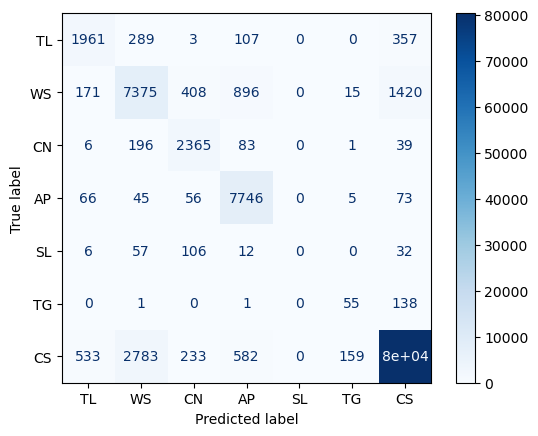

In [29]:
y_true = inference_ref_['class_code']  # True labels from the reference dataset
y_pred = inference_ref_['prediction']  # Predicted labels from your inference results

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=ref['class_code'].unique())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ref['class_code'].unique())
disp.plot(cmap=plt.cm.Blues)

# Save the plot
out_png = os.path.join(results_dir, 'denver-resnet18-inference_ms-footprints_confmat.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [30]:
# Generate classification report
report_dict = classification_report(y_true, y_pred, target_names=ref['class_code'].unique(), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_df

,precision,recall,f1-score,support
TL,0.821682,0.969341,0.889425,7991.000000
WS,0.745822,0.879182,0.807030,2690.000000
CN,0.975005,0.949294,0.961978,84606.000000
AP,0.000000,0.000000,0.000000,213.000000
SL,0.234043,0.282051,0.255814,195.000000
TG,0.714911,0.721752,0.718315,2717.000000
CS,0.686302,0.717064,0.701346,10285.000000
accuracy,0.918314,0.918314,0.918314,0.918314
macro avg,0.596823,0.645526,0.619130,108697.000000
weighted avg,0.921003,0.918314,0.918906,108697.000000


In [31]:
# Save the classification report
out_fp = os.path.join(results_dir,'denver-resnet18-inference_ms-footprints_report.csv')
report_df.to_csv(out_fp)

In [32]:
# Bar plot of F1-score

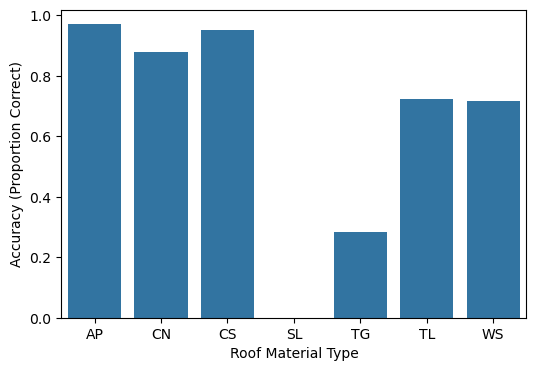

In [33]:
inference_ref_['agreement'] = inference_ref_['class_code'] == inference_ref_['prediction']
acc = inference_ref_.groupby('class_code')['agreement'].mean().reset_index()

# Plot the agreement percentages by class
plt.figure(figsize=(6, 4))
sns.barplot(x='class_code', y='agreement', data=acc)
plt.ylabel('Accuracy (Proportion Correct)')
plt.xlabel('Roof Material Type')

# Save the plot
out_png = os.path.join(results_dir, 'denver-resnet18-inference_ms-footprints_accuracy.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [34]:
gc.collect()

188